In [10]:
#!/usr/bin/env python3
import tensorflow as tf

import time

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import json

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.postprocessing import ModelHandler

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [11]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [12]:
model_handle =  ModelHandler("PBHM-HLSTM",
                           r"F:\11_EFFORS\python\models\20240617_PBHM-HLSTM-MSE-min_max",
                           is_final_model = True,
                           color = "#a65628",
                           ls = "-",
                          )

## load model and data

In [41]:
# initalize
m  = 100 # number of lamellas to approximate integral, m=100 for results - m=1 for testing
hindcast_len = len(model_handle.feat_hindcast)
forecast_len = len(model_handle.feat_forecast)

# load datamodel
dm = DataModelCV(DATA_PATH,
       target_name       = model_handle.target_name,
       hincast_features  = model_handle.feat_hindcast,
       forecast_features = model_handle.feat_forecast,
     )

# load trial data
with open(os.path.join(model_handle.hp_path, "trial.json")) as f:
    trial = json.load(f)

dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_len}.pkl"))


dfs = {}
ig_0_peaks = np.zeros((5,hindcast_len,2))
ig_1_peaks = np.zeros((5,forecast_len,2))

for n_fold in range(5):
    # load dataset
    X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

    # get baseline input
    X_base = tf.zeros_like(X[0])

    # load model
    tf.keras.backend.clear_session()
    keras_save_file_path = os.path.join(model_handle.hp_path, f"model_fold_{n_fold:d}.keras")
    model  = tf.keras.models.load_model(keras_save_file_path,
                                   custom_objects={'peak_loss'    : loss_peak_mse,  # dummy as no costum functions are saved by keras
                                                  'loss_nkge_nnse': loss_peak_mse}) #

    # find indcies of 2 most prominent flood events
    idx_1  = np.argmax(np.max(y, axis=1), axis=0)[0]
    y2 = y.copy()
    y2[idx_1-2*96:idx_1+2*96] = 0
    idx_2  = np.argmax(np.max(y2, axis=1), axis=0)[0]
    
    peak_indices = [idx_1, idx_2]

    peak_intgrad_0 = []
    peak_intgrad_1 = []
    peak_dfs = []
    for n, idx in enumerate(peak_indices):
        all_intgrad_0 = 0 # ig sum for hindcasts
        all_intgrad_1 = 0 # ig sum for forecasts
        df = pd.DataFrame()
        for offset in range(96):
            print(offset, end="\r")
            
            X_tensor_0 = tf.convert_to_tensor(X[0][[idx+offset],:,:], dtype=tf.float32)
            X_tensor_1 = tf.convert_to_tensor(X[1][[idx+offset],:,:], dtype=tf.float32)
            
            base_tensor_0 = tf.zeros_like(X_tensor_0)
            base_tensor_1 = tf.zeros_like(X_tensor_1)
            
            offset_tensor_0 = (X_tensor_0 - base_tensor_0) / tf.constant(m, dtype=tf.float32)
            offset_tensor_1 = (X_tensor_1 - base_tensor_1) / tf.constant(m, dtype=tf.float32)
            
            for k in range(1, m+1):
                inp_tensor_0 = X_tensor_0 + tf.constant(k, dtype=tf.float32) * offset_tensor_0
                inp_tensor_1 = X_tensor_1 + tf.constant(k, dtype=tf.float32) * offset_tensor_1
                inp_tensor_list = [inp_tensor_0 , inp_tensor_1]
            
                with tf.GradientTape() as t:
                    t.watch(inp_tensor_0)
                    t.watch(inp_tensor_1)
                    output = tf.math.reduce_max(model(inp_tensor_list), axis=1) # analysis at model output peak 
                    #output = model(inp_tensor_list)[:, offset] # analysis at flood event peak 
        
                grad_0, grad_1 = t.gradient(output, inp_tensor_list)
                
                if k == 1:
                    total_grad_0 = grad_0
                    total_grad_1 = grad_1
                else:
                    total_grad_0 += grad_0
                    total_grad_1 += grad_1
            
            integrated_grad_0 = offset_tensor_0 * total_grad_0
            integrated_grad_1 = offset_tensor_1 * total_grad_1
        
            df.loc[offset, ["h_" + x for x in model_handle.feat_hindcast]] = np.sum(np.sum(np.abs(integrated_grad_0), axis=0), axis=0)
            df.loc[offset, ["f_" + x for x in model_handle.feat_forecast]] = np.sum(np.sum(np.abs(integrated_grad_1), axis=0), axis=0)
        
            # total sum 
            all_intgrad_0 += np.sum(np.sum(np.abs(integrated_grad_0), axis=0), axis=0)
            all_intgrad_1 += np.sum(np.sum(np.abs(integrated_grad_1), axis=0), axis=0)

        dfs[f"fold-{n_fold}_peak-{n}"] = df.copy()
        ig_0_peaks[n_fold, :, n] = all_intgrad_0
        ig_1_peaks[n_fold, :, n] = all_intgrad_1
df = pd.concat(dfs)

dictonary loaded


In [42]:
# save results
np.save(r"src\rst\ig_peaks_hindcasts.npy", ig_0_peaks)
np.save(r"src\rst\ig_peaks_forecasts.npy", ig_1_peaks)
df.to_pickle(r"src\rst\ig_peaks.pkl")

ig_0_peaks = np.load(r"src\rst\ig_peaks_hindcasts.npy")
ig_1_peaks = np.load(r"src\rst\ig_peaks_forecasts.npy")
df = pd.read_pickle(r"src\rst\ig_peaks.pkl")


## summary of hindcast features - 2 major peaks all folds for fold models

In [43]:
ig_h_sum = np.sum(np.sum(np.abs(ig_0_peaks), axis=0), axis=1) # sum of absolute gradients hindcast features
ig_h_sum

array([ 349.5986166 ,   53.81801128,  349.88061047,  145.66534805,
       1031.04454994])

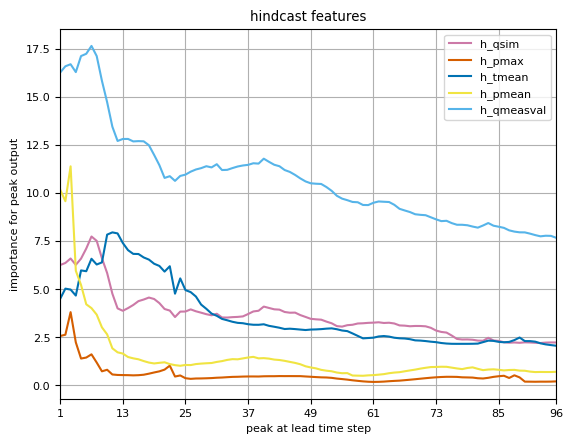

In [44]:
colors = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#56B4E9"]

fig,ax = plt.subplots(1,1)

for n, col in enumerate(df.filter(like="h").columns):
    ax.plot(df.groupby(level=1).sum()[col], c=colors[n], label=col)
    
ax.set_title("hindcast features")
ax.set_xlabel("peak at lead time step")
ax.set_ylabel("importance for peak output")
ax.set_xticks([0] + [x for x in range(11,98,12)])
ax.set_xticklabels([f"{int(95-x)+1:d}" for x in ax.get_xticks()])
ax.set_xlim([95,0])
#ax.set_ylim([0,17.5])
plt.legend()
plt.grid()


In [45]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, "figX-ig_2-peaks-2017-hindcast_summary.png"), bbox_inches="tight")

## summary of forcast features - 2 major peaks all folds for fold models¶

In [46]:
ig_f_sum = np.sum(np.sum(np.abs(ig_1_peaks), axis=0), axis=1) # sum of absolute gradients forecast features
ig_f_sum

array([ 349.5986166 ,   53.81801128,  349.88061047,  145.66534805,
       1031.04454994])

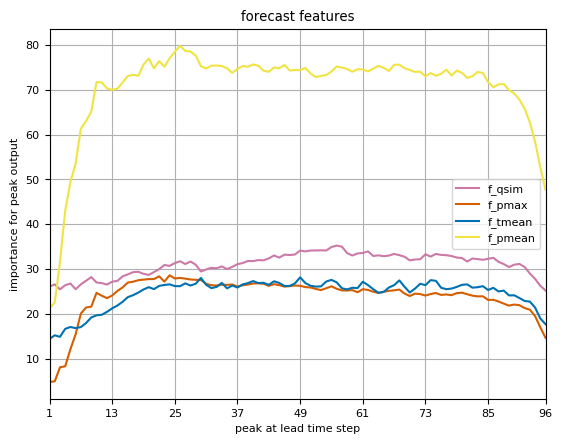

In [47]:
colors = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#56B4E9"]

fig, ax = plt.subplots(1,1)
for n, col in enumerate(df.filter(like="f").columns):
    ax.plot(df.groupby(level=1).sum()[col], c=colors[n], label=col)
    
ax.set_title("forecast features")
ax.set_xlabel("peak at lead time step")
ax.set_ylabel("importance for peak output")
ax.set_xticks([0] + [x for x in range(11,98,12)])
ax.set_xticklabels([f"{int(95-x)+1:d}" for x in ax.get_xticks()])
ax.set_xlim([95,0])
#ax.set_ylim([0,17.5])
plt.legend()
plt.grid()

In [48]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, "figX-ig_2-peaks-2017-forecast_summary.png"), bbox_inches="tight")